In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import hashlib
import time


In [2]:

class PanoramaStitcher:
    def __init__(self  ):
        self.cache = {}
        pass

    def _create_detector(self, detector_type):
        detector_type = detector_type.lower()
        if detector_type == 'sift':
            detector = cv2.SIFT_create()
            return detector, detector, False
        elif detector_type == 'orb':
            detector = cv2.ORB_create()
            return detector, detector, False
        elif detector_type == 'fast+brief':
            detector = cv2.FastFeatureDetector_create()
            descriptor = cv2.xfeatures2d.BriefDescriptorExtractor_create()
            return detector, descriptor, True
        else:
            raise ValueError(f"Unsupported detector type: {detector_type}")

    def _create_matcher(self, matcher_type, detector_type):
        matcher_type = matcher_type.lower()
        if matcher_type == 'bf':
            norm = cv2.NORM_L2 if detector_type in ['sift', 'surf'] else cv2.NORM_HAMMING
            return cv2.BFMatcher(norm, crossCheck=False)
        elif matcher_type == 'flann':
            if detector_type in ['sift', 'surf']:
                index_params = dict(algorithm=1, trees=5)
            else:
                index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
            search_params = dict(checks=50)
            return cv2.FlannBasedMatcher(index_params, search_params)
        else:
            raise ValueError(f"Unsupported matcher type: {matcher_type}")

    def display_images(self, title1, img1, title2, img2):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        plt.title(title1)
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        plt.title(title2)
        plt.axis('off')
        plt.show()

    def display_single_image(self, title, img):
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()

    def get_keypoints_and_descriptors(self, img1, img2, detector, descriptor, use_separate_descriptor):
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        if use_separate_descriptor:
            kp1 = detector.detect(gray1, None)
            kp2 = detector.detect(gray2, None)
            kp1, des1 = descriptor.compute(gray1, kp1)
            kp2, des2 = descriptor.compute(gray2, kp2)
        else:
            kp1, des1 = detector.detectAndCompute(gray1, None)
            kp2, des2 = detector.detectAndCompute(gray2, None)

        img1_kp = cv2.drawKeypoints(img1, kp1, None)
        img2_kp = cv2.drawKeypoints(img2, kp2, None)
        # self.display_images("Keypoints Image 1", img1_kp, "Keypoints Image 2", img2_kp)

        return kp1, des1, kp2, des2 , img1_kp , img2_kp 

    def match_keypoints(self, kp1, kp2, des1, des2, matcher, img1=None, img2=None):
        matches = matcher.knnMatch(des1, des2, k=2)
        good = []
        good_cv2 = []

        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                pt1 = kp1[m.queryIdx].pt
                pt2 = kp2[m.trainIdx].pt
                good.append([pt1[0], pt1[1], pt2[0], pt2[1]])
                good_cv2.append([m])

        # if img1 is not None and img2 is not None:
        match_img = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_cv2, None, flags=2)
            # self.display_single_image("Matched Keypoints", match_img)

        return good , match_img

    def compute_homography_ransac(self, good_matches, threshold=5):
        best_inliers = []
        final_H = None
        for _ in range(1000):
            sample = random.choices(good_matches, k=4)
            H = self._compute_homography(sample)
            inliers = []
            for pt in good_matches:
                src = np.array([pt[0], pt[1], 1]).reshape(3, 1)
                dst = np.array([pt[2], pt[3], 1]).reshape(3, 1)
                proj = np.dot(H, src)
                proj /= proj[2]
                if np.linalg.norm(proj - dst) < threshold:
                    inliers.append(pt)
            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                final_H = H
        return final_H

    def _compute_homography(self, points):
        A = []
        for pt in points:
            x, y, X, Y = pt
            A.append([x, y, 1, 0, 0, 0, -X*x, -X*y, -X])
            A.append([0, 0, 0, x, y, 1, -Y*x, -Y*y, -Y])
        A = np.array(A)
        _, _, Vt = np.linalg.svd(A)
        H = Vt[-1].reshape(3, 3)
        return H / H[2, 2]
    
    def hash_image(self , image: np.ndarray) -> str:
        return hashlib.md5(image.tobytes()).hexdigest()
        
    
    
    def stitch(self, img1, img2, detector='sift', matcher='bf', blending_type='optimal_seam'):
        h1, w1 = img2.shape[:2]
        h2, w2 = img1.shape[:2]
        
        self.display_images("Input Image 1", img1, "Input Image 2", img2)
    
        img1_hash = self.hash_image(img1)
        img2_hash = self.hash_image(img2)
    
        cache_key = (img1_hash, img2_hash, detector, matcher)
    
        if cache_key in self.cache:
            warped_img, xmin, ymin, exec_time, img1_kp, img2_kp, match_img, logs = self.cache[cache_key]
            print(f"\n[Cache Hit] Using Cached Warped Image. Saved Time: {exec_time:.4f} seconds")
            print("[Cache Log]")
            print(logs)
        else:
            start_time = time.time()
    
            detector_obj, descriptor_obj, use_sep_desc = self._create_detector(detector)
            matcher_obj = self._create_matcher(matcher, detector)
    
            kp1, des1, kp2, des2, img1_kp, img2_kp = self.get_keypoints_and_descriptors(img1, img2, detector_obj, descriptor_obj, use_sep_desc)
            log = f"\n[Keypoints] Image 1: {len(kp1)}, Image 2: {len(kp2)}"
    
            good_matches, match_img = self.match_keypoints(kp1, kp2, des1, des2, matcher_obj, img1, img2)
            log += f"\n[Matches] Good Matches: {len(good_matches)}"
    
            H = self.compute_homography_ransac(good_matches)
            if H is None:
                raise ValueError("Failed to compute homography. Try different images or detector.")
    
            # Estimate number of inliers
            inliers = 0
            for pt in good_matches:
                src = np.array([pt[0], pt[1], 1]).reshape(3, 1)
                dst = np.array([pt[2], pt[3], 1]).reshape(3, 1)
                proj = np.dot(H, src)
                proj /= proj[2]
                if np.linalg.norm(proj - dst) < 5:
                    inliers += 1
            log += f"\n[RANSAC] Inliers: {inliers} / {len(good_matches)}"
    
            corners_img2 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
            corners_img1 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
            corners_img1_warped = cv2.perspectiveTransform(corners_img1, H)
    
            all_corners = np.concatenate((corners_img2, corners_img1_warped), axis=0)
            [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
            [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    
            translation = np.array([[1, 0, -xmin], [0, 1, -ymin], [0, 0, 1]])
            warped_img = cv2.warpPerspective(img1, translation.dot(H), (xmax - xmin, ymax - ymin))
    
            exec_time = time.time() - start_time
            self.cache[cache_key] = (warped_img, xmin, ymin, exec_time, img1_kp, img2_kp, match_img, log)
    
            print(f"\n[Info] Warped image computed and cached. Time Taken: {exec_time:.4f} seconds")
            print(log)
    
        start_time = time.time()
    
        self.display_images("Keypoints Image 1", img1_kp, "Keypoints Image 2", img2_kp)
        self.display_single_image("Matched Keypoints", match_img)
        self.display_single_image("Warped Image 1 onto Image 2 plane", warped_img)
    
        if blending_type == 'none':
            warped_img[-ymin:h1 - ymin, -xmin:w1 - xmin] = img2
        elif blending_type == 'feather':
            warped_img = self.feather_blend(warped_img, img2, -xmin, -ymin)
        elif blending_type == 'poisson':
            warped_img = self.poisson_blend(warped_img, img2, -xmin, -ymin)
        elif blending_type == 'optimal_seam':
            warped_img = self.optimal_seam_blend(warped_img, img2, -xmin, -ymin)
    
        self.display_single_image("Final Stitched Panorama", warped_img)
    
        blend_time = time.time() - start_time
        total_time = exec_time + blend_time
        print(f"\n[Info] Total Execution Time: {total_time:.4f} seconds")
    
        return warped_img, total_time

    def feather_blend(self, base, overlay, x_offset, y_offset):
        h, w = overlay.shape[:2]
        for y in range(h):
            for x in range(w):
                if np.any(overlay[y, x] > 0):
                    alpha = 0.5
                    base[y + y_offset, x + x_offset] = (
                        alpha * overlay[y, x] + (1 - alpha) * base[y + y_offset, x + x_offset]
                    ).astype(np.uint8)
        return base

    def poisson_blend(self, base, overlay, x_offset, y_offset):
        center = (overlay.shape[1] // 2 + x_offset, overlay.shape[0] // 2 + y_offset)
        mask = (overlay[..., 0] > 0).astype(np.uint8) * 255
        return cv2.seamlessClone(overlay, base, mask, center, cv2.NORMAL_CLONE)

    def optimal_seam_blend(self, base, overlay, x_offset, y_offset):
        h, w = overlay.shape[:2]
        region1 = base[y_offset:y_offset+h, x_offset:x_offset+w]
        mask1 = (region1.sum(axis=2) > 0).astype(np.uint8)
        mask2 = (overlay.sum(axis=2) > 0).astype(np.uint8)

        overlap = mask1 & mask2
        dist1 = cv2.distanceTransform((mask1 * 255).astype(np.uint8), cv2.DIST_L2, 5)
        dist2 = cv2.distanceTransform((mask2 * 255).astype(np.uint8), cv2.DIST_L2, 5)

        total = dist1 + dist2 + 1e-6
        alpha = dist1 / total

        blend_region = region1 * alpha[:, :, None] + overlay * (1 - alpha[:, :, None])
        result = base.copy()
        result[y_offset:y_offset+h, x_offset:x_offset+w] = blend_region.astype(np.uint8)
        return result


In [3]:
stitcher = PanoramaStitcher()

In [4]:
img1 = cv2.imread('img_4a.jpg')
img2 = cv2.imread('img_4b.jpg')

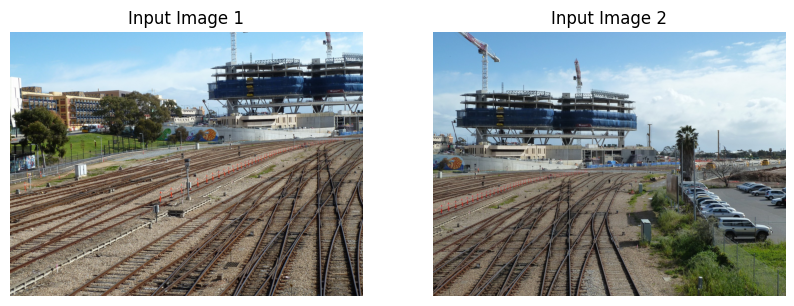


[Info] Warped image computed and cached. Time Taken: 29.9508 seconds

[Keypoints] Image 1: 14657, Image 2: 10036
[Matches] Good Matches: 2276
[RANSAC] Inliers: 1480 / 2276


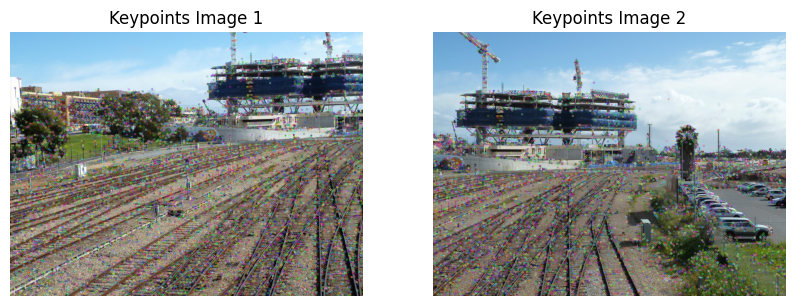

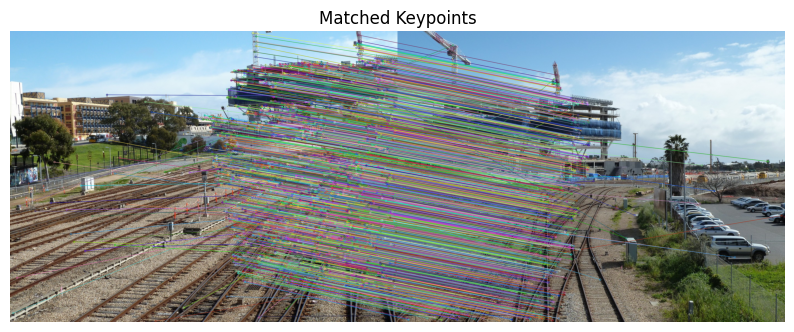

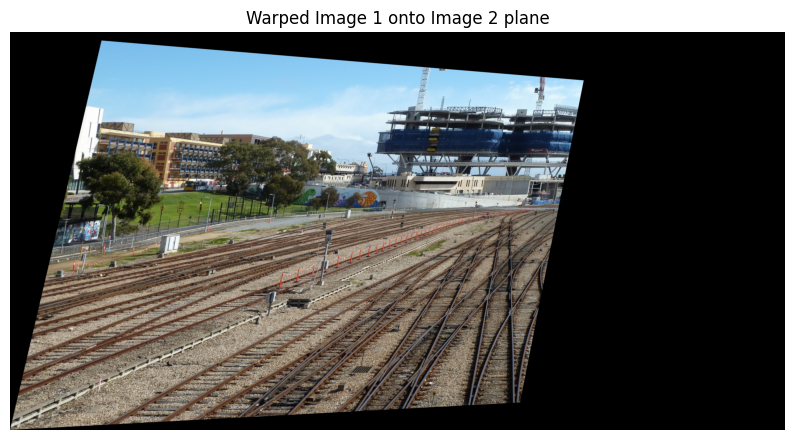

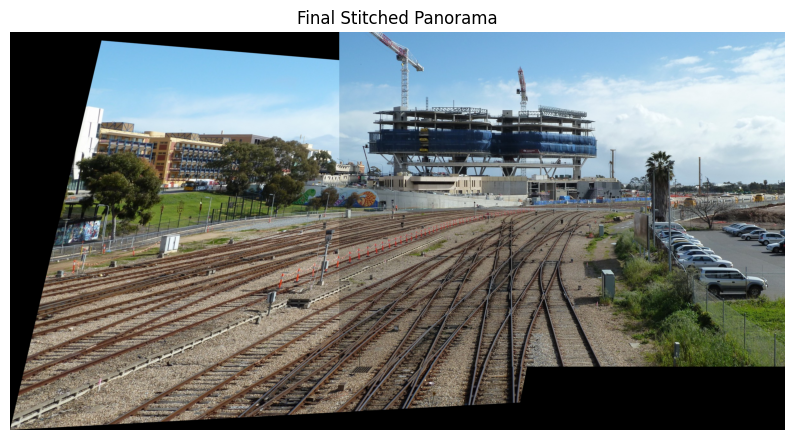


[Info] Total Execution Time: 31.9965 seconds


In [5]:
result = stitcher.stitch(img1, img2 , detector = 'sift' , matcher = 'bf' , blending_type = 'none' )

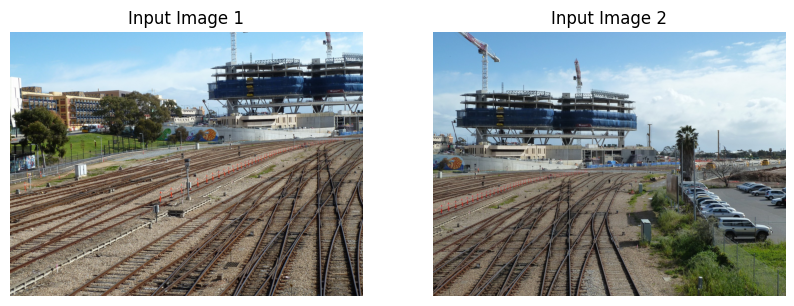


[Cache Hit] Using Cached Warped Image. Saved Time: 29.9508 seconds
[Cache Log]

[Keypoints] Image 1: 14657, Image 2: 10036
[Matches] Good Matches: 2276
[RANSAC] Inliers: 1480 / 2276


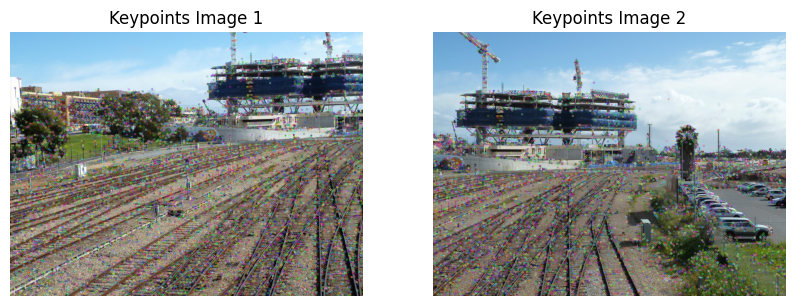

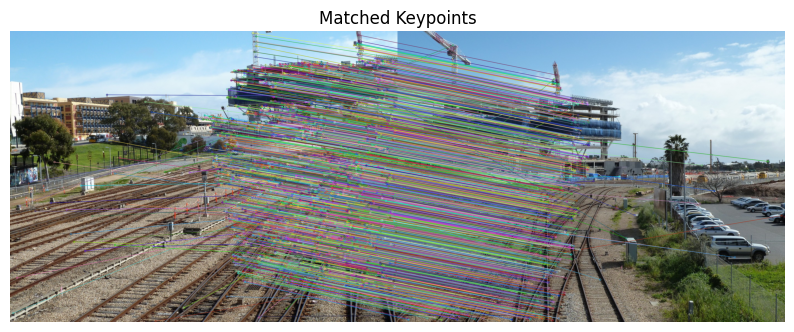

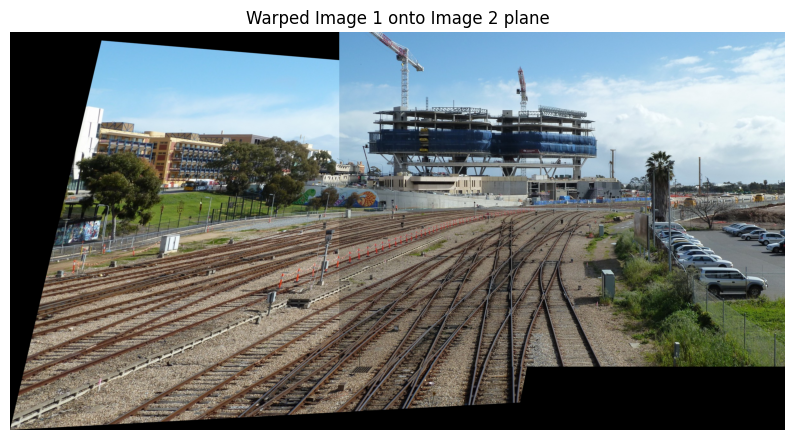

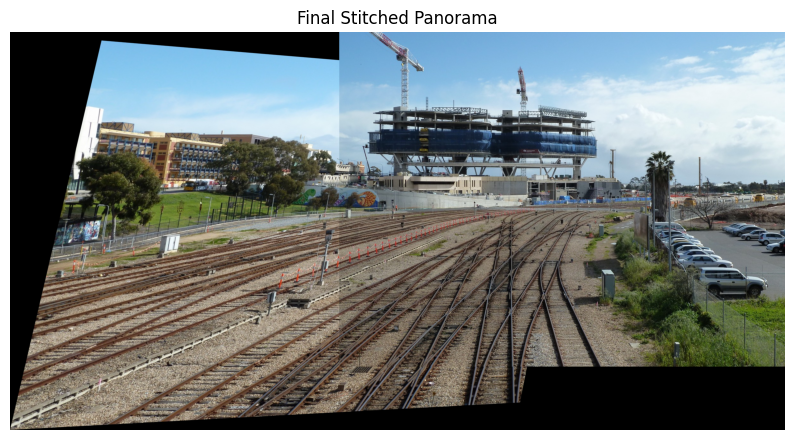


[Info] Total Execution Time: 32.8898 seconds


In [6]:
result = stitcher.stitch(img1, img2 , detector = 'sift' , matcher = 'bf' , blending_type = 'poisson' )